In [2]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import json

In [3]:
DATA_PATH = "dataset/static/landmarks"
CACHE_DIR = "dataset/static/cache"
os.makedirs(CACHE_DIR, exist_ok=True)
X_FILE = os.path.join(CACHE_DIR, "X.npy")
Y_FILE = os.path.join(CACHE_DIR, "y.npy")
LABEL_MAP_FILE = os.path.join(CACHE_DIR, "label_map.json")

In [4]:
if os.path.exists(X_FILE) and os.path.exists(Y_FILE) and os.path.exists(LABEL_MAP_FILE):
    print("Loading cached data...")
    X = np.load(X_FILE)
    y = np.load(Y_FILE)
    with open(LABEL_MAP_FILE, "r") as f:
        label_map = json.load(f)
else:
    print("Processing data from scratch...")
    labels = sorted(os.listdir(DATA_PATH))  # ['A', 'B', ..., 'Z']
    label_map = {label: idx for idx, label in enumerate(labels)}
    
    X, y = [], []

    for label in labels:
        folder_path = os.path.join(DATA_PATH, label)
        for file in os.listdir(folder_path):
            if file.endswith(".npy"):
                data = np.load(os.path.join(folder_path, file))
                X.append(data)
                y.append(label_map[label])

    X = np.array(X)  # shape: (num_samples, 63)
    y = np.array(y)

    # Save cached data
    np.save(X_FILE, X)
    np.save(Y_FILE, y)
    with open(LABEL_MAP_FILE, "w") as f:
        json.dump(label_map, f)

Loading cached data...


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [6]:
num_classes = len(label_map)
y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_test_encoded = to_categorical(y_test, num_classes=num_classes)

print("X_train shape:", X_train.shape)
print("y_train_encoded shape:", y_train_encoded.shape)

X_train shape: (45680, 63)
y_train_encoded shape: (45680, 26)


In [7]:
print("X_test shape:", X_test.shape)
print("y_test_encoded shape:", y_test_encoded.shape)

X_test shape: (11420, 63)
y_test_encoded shape: (11420, 26)


In [8]:
input_shape = (63,)
num_classes = len(label_map)  # 26 for A-Z

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')  # Multi-class output
])

In [9]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               8192      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 26)                1690      
                                                                 
Total params: 18138 (70.85 KB)
Trainable params: 18138 (70.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
checkpoint_path = "models/best_asl_landmark_model.h5"
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
callbacks = [
    EarlyStopping(
        monitor='val_loss', 
        patience=5, 
        restore_best_weights=True, 
        verbose=1),
    ModelCheckpoint(
        checkpoint_path, 
        monitor='val_loss', 
        save_best_only=True, 
        save_weights_only=False,
        verbose=1)  
]


In [11]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/50


1406/1428 [============================>.] - ETA: 0s - loss: 1.4866 - accuracy: 0.5475
Epoch 1: val_loss improved from inf to 0.42613, saving model to models\best_asl_landmark_model.h5
1428/1428 [==============================] - 3s 1ms/step - loss: 1.4743 - accuracy: 0.5512 - val_loss: 0.4261 - val_accuracy: 0.9208
Epoch 2/50
  97/1428 [=>............................] - ETA: 2s - loss: 0.6149 - accuracy: 0.8054

c:\Users\acer\miniconda3\envs\asl_env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1390/1428 [============================>.] - ETA: 0s - loss: 0.4974 - accuracy: 0.8437
Epoch 2: val_loss improved from 0.42613 to 0.25185, saving model to models\best_asl_landmark_model.h5
1428/1428 [==============================] - 2s 2ms/step - loss: 0.4939 - accuracy: 0.8447 - val_loss: 0.2519 - val_accuracy: 0.9160
Epoch 3/50
1419/1428 [============================>.] - ETA: 0s - loss: 0.3332 - accuracy: 0.8963
Epoch 3: val_loss improved from 0.25185 to 0.17438, saving model to models\best_asl_landmark_model.h5
1428/1428 [==============================] - 2s 2ms/step - loss: 0.3331 - accuracy: 0.8964 - val_loss: 0.1744 - val_accuracy: 0.9511
Epoch 4/50
1427/1428 [============================>.] - ETA: 0s - loss: 0.2668 - accuracy: 0.9175
Epoch 4: val_loss improved from 0.17438 to 0.13245, saving model to models\best_asl_landmark_model.h5
1428/1428 [==============================] - 3s 2ms/step - loss: 0.2667 - accuracy: 0.9175 - val_loss: 0.1325 - val_accuracy: 0.9701
Epoch 5/50
1

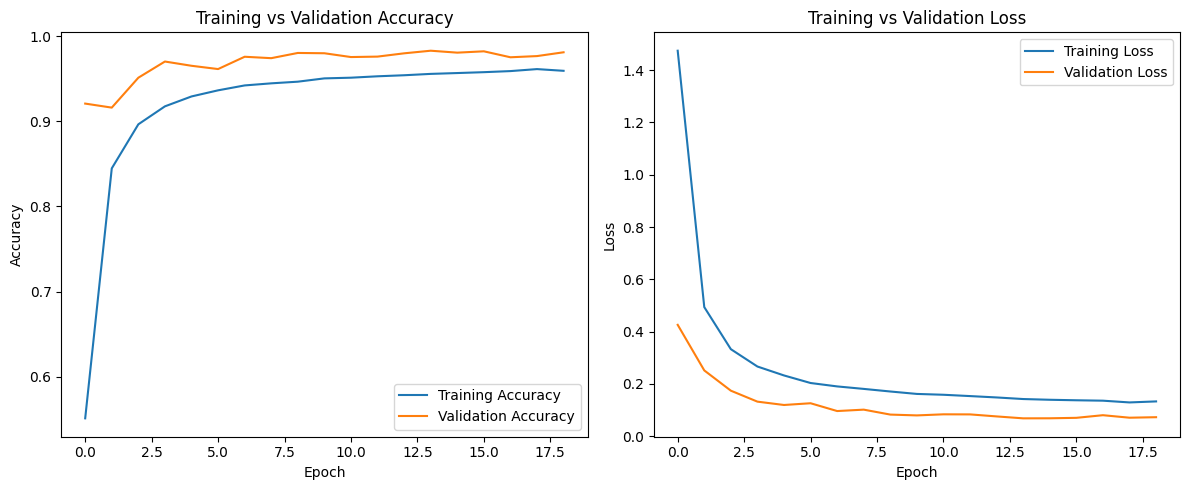

In [12]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

plot_training_history(history)